In [1]:
from obspy.taup import TauPyModel
model = TauPyModel(model="ak135irelandcrust")
from obspy.geodetics import degrees2kilometers, gps2dist_azimuth
from pyproj import Geod
geod = Geod(ellps="WGS84")
from obspy.geodetics import locations2degrees
import pandas as pd
import numpy as np
import pygmt
from multiprocessing import Pool

In [2]:
seisblast_files = '/home/bmelo/Quarry/Quarry-Blast/tomo/'

# Load station data to lon lat file and dataframe
quarries = pd.read_csv(
    seisblast_files + 'lists/IRELAND.quarry.coords.txt',
    sep = r'\s+',
    header=None,
    names=['name','co','lat','lon'])

blasts_catalogue = pd.read_csv(
    seisblast_files + 'catalogues/quarry-blast-catalog-all.csv',
    sep=r'\s+',
    header=None,
    names=['ID','date','time','lat','lat-err','lon','lon-err','depth','rms','az','n','magnitude'])

stations = pd.read_csv(
    seisblast_files + 'lists/Total_Stations_List.txt', 
    delimiter=' ',
    names=['sta', 'name','lat', 'lon', 'elevation', 'net', 'end'])

uniq_blasts = pd.read_csv('/home/bmelo/Quarry/Quarry-Blast/tomo/seisblast/uniq_quarry-station_list.csv')
uniq_blasts

,closest-ev_id,quarry-lat,quarry-lon,origin_time,mag,sta,closest-time,count
0,dias2013kwhe,54.3797,-7.378597,2013-06-04 11:58:42.744,1.29,"['D34', 'DL31', 'IDGL', 'UCRUI']","[13.873, 10.696, 13.043, 16.183]",4
1,dias2013kwks,52.8995,-9.038942,2013-06-04 13:45:39.377,1.56,"['IA002', 'IA009', 'IAD01', 'UCAR3', 'UD10', '...","[27.592, 18.393, 3.43, 12.756, 35.399, 24.536,...",4
2,dias2013kwle,53.4341,-7.138017,2013-06-04 14:00:17.523,1.18,['UCD11'],[10.823],4
3,dias2013kwlj,52.5985,-7.200083,2013-06-04 14:05:07.330,1.16,['UHELL'],[15.765],4
4,dias2013kwls,53.3092,-9.007666,2013-06-04 14:16:21.183,1.71,"['DSB', 'IA009', 'IA013', 'IAD01', 'UCAR2', 'U...","[28.79, 10.624, 21.342, 10.326, 10.139, 29.416...",3
...,...,...,...,...,...,...,...,...
2499,dias2024yqnt,54.9011,-6.278509,2024-12-16 13:58:48.159,0.82,"['CLGH', 'DGL2', 'GAL1', 'LAWE']","[4.04, 22.123, 17.111, 26.181]",5
2500,dias2024yslh,53.3092,-9.007666,2024-12-17 15:00:59.257,0.83,['IGLA'],[4.6],4
2501,dias2024yucz,53.5524,-8.184939,2024-12-18 13:06:00.173,0.97,['ITIP'],[9.762],4
2502,dias2024yvyj,52.9731,-7.522619,2024-12-19 13:01:29.362,0.96,['IBMH'],[16.37],4


In [4]:
def get_ray_info(index_src):
    """
    Computes and plots ray paths for a given source and returns ray path data.
    
    Parameters:
    index_src (int): Index of the quarry in the dataframe.
    type (str): Type of plot ('map' or 'cross-section').
    ax (pygmt.Figure or matplotlib.Axes): Plotting object.
    
    Returns:
    pd.DataFrame: DataFrame containing ray path latitude, longitude, and depth.
    """
    quarry = uniq_blasts.iloc[index_src]
    q_lat, q_lon = quarry['quarry-lat'], quarry['quarry-lon']
    st_list = eval(quarry['sta'])
    ray_data = pd.DataFrame()
    ray_data_list = []
    # Loop over stations
    for st_id in st_list:
        station_info = stations.loc[stations['name'] == st_id].squeeze()
        # Compute azimuth and epicentral distance
        _, azimuth, _ = gps2dist_azimuth(
            q_lat, 
            q_lon, 
            station_info['lat'], 
            station_info['lon'])
        dist_in_deg = locations2degrees(
            q_lat,
            q_lon,
            station_info['lat'],
            station_info['lon'])
        # Get ray paths from TauP
        arrivals = model.get_ray_paths(
            0,  # source depth
            dist_in_deg,  # distance in degrees
            ["P"],  # phase
            0)  # station elevation?

        if arrivals:
            arrival = arrivals[0]
            # Create ray path data for the current station
            ray_data_current = pd.DataFrame({
                'event-ID': [quarry['closest-ev_id']],
                'station': [st_id],
                'station_lon': [station_info['lon']],
                'station_lat': [station_info['lat']],
                'quarry_lon': [q_lon],
                'quarry_lat': [q_lat],
                'lon': [list(q_lon + (np.rad2deg(arrival.path['dist']) * np.sin(np.radians(azimuth))) / np.cos(np.radians(q_lat)))],
                'lat': [list(q_lat + np.rad2deg(arrival.path['dist']) * np.cos(np.radians(azimuth)))],
                'depth': [list(-arrival.path['depth'])]
            })
            # Concatenate with the main ray data DataFrame
            #ray_data = pd.concat([ray_data, ray_data_current], ignore_index=True)
            ray_data_list.append(ray_data_current)
    
    if ray_data_list:
        return pd.concat(ray_data_list, ignore_index=True)
    return pd.DataFrame()

In [6]:
# # Process all list
n_cores = 60
ray_info = pd.DataFrame()

# Create the pool and process in parallel
with Pool(n_cores) as pool:
    ray_info_list = pool.map(get_ray_info, range(len(uniq_blasts)))  # or range(len(uniq_blasts))
    
# Remove any empty DataFrames (if any station had no arrivals)
ray_info_list = [df for df in ray_info_list if not df.empty]

# Concatenate all at once (much faster than incremental concat)
ray_info = pd.concat(ray_info_list, ignore_index=True)

# Save ray path data to CSV
ray_info.to_csv(
    seisblast_files + "seisblast/ray_path_data.csv", 
    index=False, 
    sep=' ')

ray_info.to_pickle(seisblast_files + "seisblast/ray_path_data.pkl")

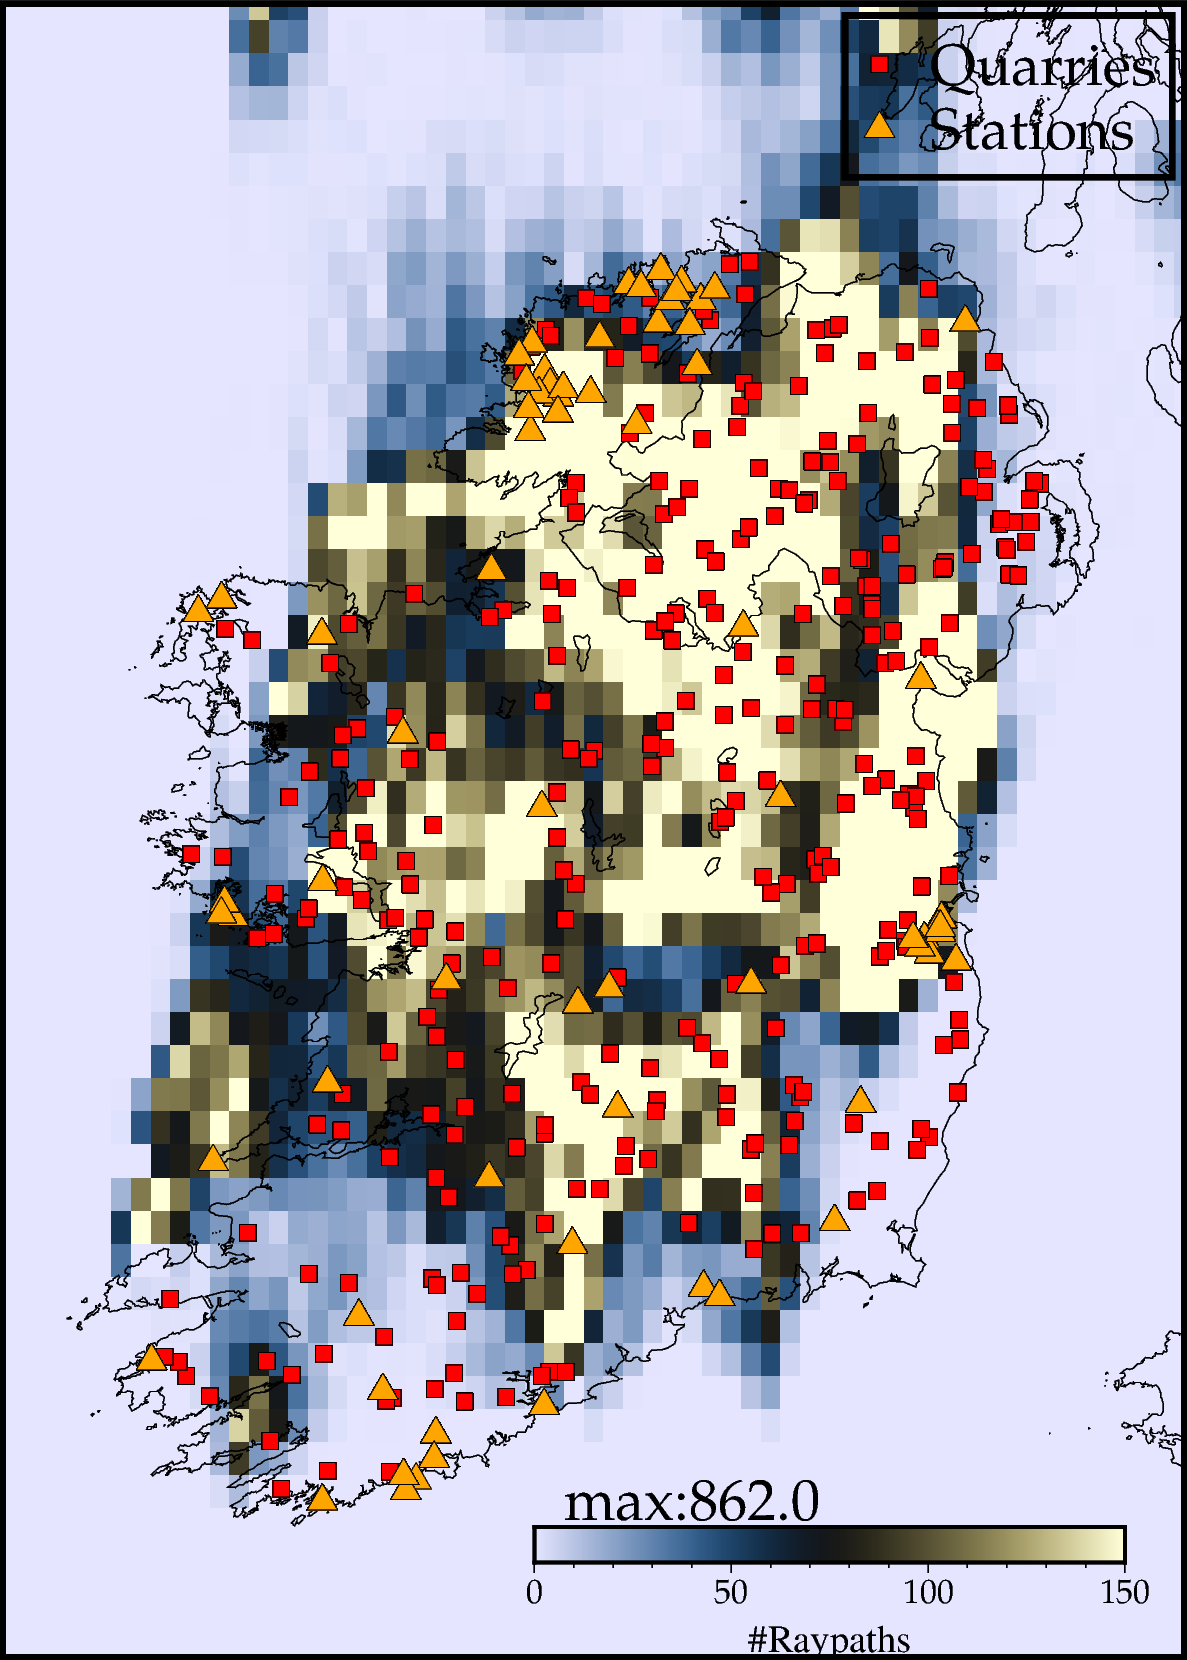

In [5]:
#plot the ray path information
pygmt.config(#FONT="12p,Palatino-Roman", 
             FONT_ANNOT_PRIMARY="14p,Palatino-Roman",
             FONT_ANNOT_SECONDARY="14p,Palatino-Roman",
             FONT_LABEL="16p,Times-Roman",
             IO_SEGMENT_MARKER="<<<",
             MAP_FRAME_TYPE = 'plain')

ray_info = pd.read_pickle(seisblast_files + "seisblast/ray_path_data.pkl")
region = [-11, -5, 51, 56]
# Combine all ray paths into a single dataset for efficient plotting
all_lons = np.concatenate(ray_info['lon'].values)
all_lats = np.concatenate(ray_info['lat'].values)

# Create a density grid using numpy.histogram2d
density, lon_edges, lat_edges = np.histogram2d(
    all_lons, all_lats, bins=[100,100], range=[[region[0], region[1]], [region[2], region[3]]]
)
# Convert the density grid to a pygmt-compatible grid
lon_centers = 0.5 * (lon_edges[:-1] + lon_edges[1:])
lat_centers = 0.5 * (lat_edges[:-1] + lat_edges[1:])

density_grid = pd.DataFrame({
    "lon": np.repeat(lon_centers, len(lat_centers)),
    "lat": np.tile(lat_centers, len(lon_centers)),
    "density": (density.T.ravel())#/density.max(),   #density is normalized?
})

ray_grid = pygmt.xyz2grd(
    data=density_grid,
    region=region,
    spacing=(0.1)
)
# Mask values below a threshold (e.g., z < 0)
threshold = 0
masked_grid = ray_grid.where(ray_grid >= threshold)

fig = pygmt.Figure()

fig.basemap(region=region, projection="M10c", frame="wesn")
pygmt.makecpt(cmap="SCM/lisbon", series=[0,150], background=False, reverse=False)
fig.grdimage(grid=masked_grid, region=region,frame=["WSne"])
fig.coast(shorelines=True, borders=1, resolution="h")
#ax.plot(x=all_lons, y=all_lats, transparency=30, pen="0.1p,black")
fig.plot(x=ray_info['quarry_lon'], y=ray_info['quarry_lat'], style="s0.2c", fill="red", pen="0.1p", label="Quarries")
fig.plot(x=ray_info['station_lon'], y=ray_info['station_lat'], style="t0.3c", fill="orange", pen="0.1p", label="Stations")
fig.colorbar(frame = ["a50f10","x+l#Raypaths"], position = "jBR+w5c/0.3c+h+o0.5/0.8")
fig.text(x=-7.5, y=51.5, text="max:"+str(density.max()))#, font="10p,Helvetica,black")
fig.legend(position="jTR+o0.1c", box=True)
    #add a subplot with the ray paths\
# Add legend
fig.show(width=800)
fig.savefig(seisblast_files + "seisblast/raypaths.png", dpi=300)